## CCS3 Exam - Gaze Data as a Feature in Fake Image Classification

This notebook contains the code for modeling fake image classification using gaze data, as presented in my paper.

### Imports

In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from scipy.ndimage import gaussian_filter

from PIL import Image
from pathlib import Path

from scipy.stats import pointbiserialr
import seaborn as sns

from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import RandomizedSearchCV

from sklearn.inspection import permutation_importance

### Loading the dataset

In [ ]:
!wget https://github.com/aimagelab/unveiling-the-truth/releases/download/v0.1.0/dataset.zip

!unzip /content/dataset.zip



--2025-12-25 14:27:48--  https://github.com/aimagelab/unveiling-the-truth/releases/download/v0.1.0/dataset.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/744522133/d8c7abec-eceb-432d-8ca4-1c3a54675bcf?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-12-25T15%3A16%3A06Z&rscd=attachment%3B+filename%3Ddataset.zip&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-12-25T14%3A15%3A07Z&ske=2025-12-25T15%3A16%3A06Z&sks=b&skv=2018-11-09&sig=10FAqwd0KRhTxalIW6UaUpqrvyARVihTw9I3sJUGYYs%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2NjY3NDY2OSwibmJmIjoxNzY2NjcyODY5LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi5i

In [ ]:
!wget https://raw.githubusercontent.com/aimagelab/unveiling-the-truth/main/visualize_scanpath.py

--2025-12-25 14:27:55--  https://raw.githubusercontent.com/aimagelab/unveiling-the-truth/main/visualize_scanpath.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2694 (2.6K) [text/plain]
Saving to: ‘visualize_scanpath.py’

visualize_scanpath. 100%[===================>]   2.63K  --.-KB/s    in 0s      

2025-12-25 14:27:55 (36.8 MB/s) - ‘visualize_scanpath.py’ saved [2694/2694]



In [ ]:
!python visualize_scanpath.py --img_id COCO_000000102210 --user=1 --type=semantic_agnostic

/content/visualize_scanpath.py:88: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data = pickle.load(fp)


### Dataset preprocessing

Loading as pandas dataframe, adding binary real/fake label and image path.

In [ ]:
with open('dataset/gaze_data.pickle', 'rb') as f:
    gaze_data = pickle.load(f)

real = ['original']
fake = ['pix2pix_magicbrush', 'semantic_agnostic', 'semantic_aware']

rows = []

for img_id, img_data in gaze_data.items():
    for edit_type, edit_data in img_data.items():
        for user_id, gaze in edit_data.items():

            label = 'real' if edit_type in real else 'fake'

            rows.append({
                'img_id': img_id,
                'edit_type': edit_type,
                'user_id': user_id,
                'rating': gaze.get('rating'),
                'timestamp': gaze.get('timestamp'),
                'x_coords': gaze.get('x_coords'),
                'y_coords': gaze.get('y_coords'),
                'ivt_classification': gaze.get('ivt_classification'),
                'x_fix': gaze.get('x_fix'),
                'y_fix': gaze.get('y_fix'),
                'label': label
            })

df = pd.DataFrame(rows)

DATASET_ROOT = Path('dataset')

df['img_path'] = df.apply(
    lambda r: DATASET_ROOT / 'images' / r.edit_type / f'{r.img_id}.jpg',
    axis=1
)

df

/tmp/ipython-input-2587556533.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  gaze_data = pickle.load(f)


,img_id,edit_type,user_id,rating,timestamp,x_coords,y_coords,ivt_classification,x_fix,y_fix,label,img_path
0,LHQ_0036500,original,user_1,1,"[83168423.7924, 83168436.3733, 83168445.8856, ...","[498.39727355714376, 498.104236390969, 498.164...","[495.7665356772788, 495.62507456084097, 495.33...","{'segments': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[499.56640079299325, 498.41784730719473, 502.0...","[495.7444998822537, 500.581541026746, 498.0708...",real,dataset/images/original/LHQ_0036500.jpg
1,LHQ_0036500,original,user_2,4,"[2385391.1434, 2385399.5385, 2385410.5657, 238...","[505.9934755057398, 505.45541147569287, 503.43...","[527.4829341898354, 527.1294695928614, 526.675...","{'segments': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[504.43633101297814, 706.4882616080149, 708.52...","[527.5525554641615, 856.063461669096, 862.2258...",real,dataset/images/original/LHQ_0036500.jpg
2,LHQ_0036500,original,user_3,4,"[4850774.3957, 4850781.2041, 4850791.8332, 485...","[508.3645731241149, 507.9305474549666, 507.024...","[519.0793238444857, 516.4819121180662, 514.486...","{'segments': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[507.04211212365277, 576.6024685995045, 581.28...","[508.9631728258399, 829.7966694690722, 840.300...",real,dataset/images/original/LHQ_0036500.jpg
3,LHQ_0036500,original,user_4,5,"[168758596.395, 168758603.6366, 168758614.3148...","[559.6502812264772, 551.6583745442607, 551.015...","[426.0392367318026, 418.28609228531576, 417.89...","{'segments': [0, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3,...","[559.6502812264772, 551.4168900637109, 549.076...","[426.0392367318026, 413.2097969546467, 416.126...",real,dataset/images/original/LHQ_0036500.jpg
4,LHQ_0036500,original,user_5,3,"[71105175.4671, 71105187.5367, 71105197.2673, ...","[513.6360809700693, 514.1566765867993, 513.584...","[510.5366045664047, 508.7774524591445, 506.673...","{'segments': [0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2,...","[513.4784138505979, 512.8495060167038, 409.871...","[507.796679755255, 508.5743830436777, 314.5599...",real,dataset/images/original/LHQ_0036500.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,LHQ_0024327,semantic_aware,user_1,2,"[94510396.4132, 94510407.221, 94510418.8265, 9...","[508.21052198446466, 508.024128201453, 507.641...","[514.8350623414879, 515.6667413784064, 515.810...","{'segments': [0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2,...","[506.9407882784553, 534.9596934543615, 537.879...","[515.3200983744217, 512.1695291778847, 512.895...",fake,dataset/images/semantic_aware/LHQ_0024327.jpg
1996,LHQ_0024327,semantic_aware,user_2,3,"[1800110.0277, 1800121.5899, 1800147.749, 1800...","[523.1021795058537, 522.154187177235, 521.1414...","[505.6635183426038, 503.6464919452719, 502.746...","{'segments': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2,...","[520.7757592645195, 524.1453577998853, 523.930...","[503.3894260356332, 501.31507967932083, 495.64...",fake,dataset/images/semantic_aware/LHQ_0024327.jpg
1997,LHQ_0024327,semantic_aware,user_3,1,"[8227187.4478, 8227194.5457, 8227204.9541, 822...","[514.47453678391, 507.65806285076843, 510.5201...","[508.6108451153664, 510.75434091655967, 509.97...","{'segments': [0, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3,...","[514.47453678391, 514.0173442097492, 517.61639...","[508.6108451153664, 509.8621851629407, 515.091...",fake,dataset/images/semantic_aware/LHQ_0024327.jpg
1998,LHQ_0024327,semantic_aware,user_4,4,"[6190036.5477, 6190048.0931, 6190073.7787, 619...","[517.7832480279513, 518.0822867914526, 518.322...","[515.0789349943296, 514.8485104110052, 514.077...","{'segments': [0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2,...","[518.4258702064853, 520.7762791535581, 522.207...","[513.805129230404, 508.2673737822045, 514.0031...",fake,dataset/images/semantic_aware/LHQ_0024327.jpg


#### Calculating entropy

Calculating the Shannon entropy, pooled across all users.

In [ ]:
def get_img_dim(img_path):
  with Image.open(img_path) as img:
    img_w, img_h = img.size

  return img_w, img_h


def saliency_map_from_fixations(x_fix, y_fix, img_w, img_h, sigma_px):
    sal = np.zeros((img_h, img_w), dtype=np.float32)

    for x, y in zip(x_fix, y_fix):
        xi = int(round(x))
        yi = int(round(y))
        if 0 <= xi < img_w and 0 <= yi < img_h:
            sal[yi, xi] += 1.0

    sal = gaussian_filter(sal, sigma=sigma_px)
    return sal

def normalize_saliency(sal):
    if sal.sum() == 0:
        return None
    return sal / sal.sum()

def saliency_entropy(sal, eps=1e-12):
    p = sal.flatten()
    p = p[p > 0]
    return -np.sum(p * np.log(p + eps))

def image_fixation_entropy(all_x_fix, all_y_fix, img_w, img_h, sigma_px):
    sal = saliency_map_from_fixations(all_x_fix, all_y_fix, img_w, img_h, sigma_px)

    sal = normalize_saliency(sal)
    if sal is None:
        return 0.0

    H = saliency_entropy(sal)
    H_norm = H / np.log(img_w * img_h)
    return H_norm

In [ ]:
def pooled_entropy(group):
    x_all = np.concatenate(group['x_fix'].values)
    y_all = np.concatenate(group['y_fix'].values)

    img_w, img_h = get_img_dim(group['img_path'].iloc[0])

    entropy = image_fixation_entropy(x_all, y_all, img_w, img_h, 40) # sigma 40 is chosen as a relative fovea sized gaussian based on viewing distance

    return entropy


entropy_df = (
    df
    .groupby(['img_id', 'edit_type'])
    .apply(pooled_entropy)
    .reset_index(name='pooled_entropy')
)

/tmp/ipython-input-2262357238.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(pooled_entropy)


#### Calculating relevant features

In [ ]:
# calculating chosen feature vectors from the gaze data
def calculate_features(x_fix, y_fix, img_path):
    x_fix = np.array(x_fix)
    y_fix = np.array(y_fix)

    if len(x_fix) > 1:
        dists = np.sqrt(np.diff(x_fix)**2 + np.diff(y_fix)**2)
        mean_sacc = np.mean(dists)
    else:
        mean_sacc = 0

    dispersion = np.sqrt(np.var(x_fix) + np.var(y_fix))

    return [
        len(x_fix), # number of fixations
        np.std(x_fix), # variance of x coordinates of the fixations
        np.std(y_fix), # variance of y coordinates of the fixations
        np.max(x_fix) - np.min(x_fix), # horizontal spread
        np.max(y_fix) - np.min(y_fix), # vertical spread
        mean_sacc, # average saccade length
        dispersion # overall spread of fixations
    ]


### Gaze only model

A random forest model trained on the gaze data to detect an image as real or fake

In [ ]:
df_rows = []
for index, sample in df.iterrows():
  feats = calculate_features(sample['x_fix'], sample['y_fix'], sample['img_path'])
  if feats is not None:
    df_rows.append(feats + [sample['label'], sample['img_id'], sample['edit_type']])

    columns = ['num_fix', 'std_x','std_y',
           'x_span','y_span','mean_saccade', 'dispersion','label','img_id','edit_type']

train_df = pd.DataFrame(df_rows, columns=columns)

train_df

,num_fix,std_x,std_y,x_span,y_span,mean_saccade,dispersion,label,img_id,edit_type
0,33,191.340728,264.860079,623.907599,777.951371,119.715245,326.744756,real,LHQ_0036500,original
1,44,191.895908,152.593553,598.669099,451.068115,90.776900,245.171025,real,LHQ_0036500,original
2,42,212.178606,176.489774,900.000121,588.531340,91.615676,275.986234,real,LHQ_0036500,original
3,40,199.605499,160.297519,828.523263,570.828707,89.954540,256.003222,real,LHQ_0036500,original
4,32,114.070213,193.527557,392.342287,585.884215,136.238042,224.644005,real,LHQ_0036500,original
...,...,...,...,...,...,...,...,...,...,...
1995,34,178.675733,163.413907,593.133237,576.515271,88.872722,242.134514,fake,LHQ_0024327,semantic_aware
1996,53,209.415443,176.746965,782.098119,651.989127,73.972678,274.033424,fake,LHQ_0024327,semantic_aware
1997,60,149.231940,118.601263,617.979708,579.771838,51.765019,190.621173,fake,LHQ_0024327,semantic_aware
1998,44,239.163903,208.246483,760.177304,751.793400,77.908034,317.121381,fake,LHQ_0024327,semantic_aware


#### Aggregating users together

In [ ]:
feature_names = ['num_fix', 'std_x', 'std_y', 'x_span', 'y_span', 'mean_saccade', 'dispersion']

agg_funcs = {}
for f in feature_names:
    agg_funcs[f] = ['mean', 'std']

df_agg = (
    train_df
    .groupby(['img_id', 'edit_type', 'label'])
    .agg(agg_funcs)
)

df_agg.columns = [
    f'{feat}_{stat}' for feat, stat in df_agg.columns
]
df_agg = df_agg.reset_index()

# adding pooled entropy measurement from above
df_agg = df_agg.merge(
    entropy_df,
    on=['img_id', 'edit_type'],
    how='left'
)

#### Investigating feature correlations

In [ ]:
df_agg_2 = df_agg.drop(['img_id', 'edit_type'], axis=1)
df_agg_2['label'] = df_agg_2['label'].astype('category').cat.codes

df_agg_2.corr()['label'][:]

,label
label,1.000000
num_fix_mean,-0.020367
num_fix_std,0.002742
std_x_mean,0.040210
std_x_std,0.039242
std_y_mean,0.042111
std_y_std,0.040929
x_span_mean,0.034512
x_span_std,0.033777
y_span_mean,0.051278


In [ ]:
# checking significance of the correlation between entropy and the label
pointbiserialr(df_agg_2['label'], df_agg_2['pooled_entropy'])

SignificanceResult(statistic=np.float64(0.11438605770623023), pvalue=np.float64(0.022133069086500808))

<Axes: xlabel='label', ylabel='pooled_entropy'>

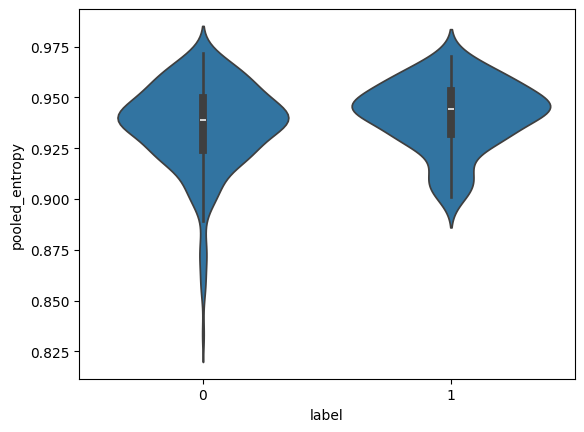

In [ ]:
sns.violinplot(x='label', y='pooled_entropy', data=df_agg_2)

#### Training the model

F1 Macro: [0.56268736 0.55357143 0.59007993 0.63386728 0.51682485]
F1-macro: 0.571 ± 0.039
              precision    recall  f1-score   support

        fake       0.80      0.73      0.76       300
        real       0.35      0.44      0.39       100

    accuracy                           0.66       400
   macro avg       0.57      0.58      0.57       400
weighted avg       0.68      0.66      0.67       400



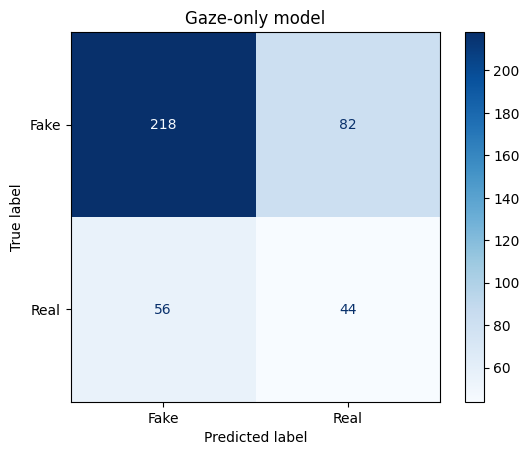

In [ ]:
gaze_only_pipe = Pipeline([
    ('clf', RandomForestClassifier(
        max_depth=8,
        min_samples_leaf=20,
        max_features='log2',
        n_estimators=300,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

X = df_agg.drop(['label', 'img_id', 'edit_type'], axis=1)
y = df_agg['label']

scores = cross_val_score(
    gaze_only_pipe, X, y,
    cv=cv,
    scoring='f1_macro'
)

print('F1 Macro:', scores)

mean_f1 = np.mean(scores)
std_f1 = np.std(scores)

print(f'F1-macro: {mean_f1:.3f} ± {std_f1:.3f}')


y_pred = cross_val_predict(
    gaze_only_pipe,
    X,
    y,
    cv=cv
)

print(classification_report(y, y_pred))

cm = confusion_matrix(y, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Fake', 'Real']
)

disp.plot(cmap='Blues', values_format='d')
plt.title('Gaze-only model')
plt.show()

#### Hyperparameter tuning

In [ ]:
param_dist = {
    'clf__n_estimators': [100, 200, 300, 500],
    'clf__max_depth': [4, 6, 8, 10, None],
    'clf__min_samples_leaf': [1, 5, 10, 20],
    'clf__max_features': ['sqrt', 'log2', 0.5, 0.75],
    'clf__class_weight': ['balanced', None]
}

search = RandomizedSearchCV(
    gaze_only_pipe,
    param_distributions=param_dist,
    n_iter=30,
    scoring='balanced_accuracy',
    cv=5,
    random_state=42,
    n_jobs=-1
)

search.fit(X, y)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('clf',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     max_depth=8,
                                                                     max_features='log2',
                                                                     min_samples_leaf=20,
                                                                     n_estimators=300,
                                                                     n_jobs=-1,
                                                                     random_state=42))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'clf__class_weight': ['balanced', None],
                                        'clf__max_depth': [4, 6, 8, 10, None],
                                        'clf__max_features': ['sqrt', 'log2',
                                                              0.5, 0.75],
                                        'clf__min_samples_leaf': [1, 5, 10, 20],
                                        'clf__n_estimators': [100, 200, 300,
                                                              500]},
                   random_state=42, scoring='balanced_accuracy')

#### Assessing model performance

In [ ]:
gaze_only_pipe.fit(X, y)

perm_importance = permutation_importance(
    gaze_only_pipe,
    X,
    y,
    scoring='f1_macro',
    n_repeats=30,
    random_state=42,
    n_jobs=-1
)

importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(importance_df)

              feature  importance_mean  importance_std
10  mean_saccade_mean         0.040452        0.013883
0        num_fix_mean         0.028148        0.008896
3           std_x_std         0.022673        0.014511
14     pooled_entropy         0.019472        0.009015
9          y_span_std         0.019435        0.005039
8         y_span_mean         0.018549        0.010052
13     dispersion_std         0.017508        0.012639
1         num_fix_std         0.017333        0.008732
7          x_span_std         0.016271        0.009436
11   mean_saccade_std         0.011806        0.006241
5           std_y_std         0.007929        0.003891
2          std_x_mean         0.005628        0.008904
6         x_span_mean         0.004368        0.007072
4          std_y_mean        -0.000185        0.011119
12    dispersion_mean        -0.003200        0.009152


### Gaze + rating models



Models using participant authenticity ratings.

In [ ]:
df_rows = []
for index, sample in df.iterrows():
  feats = calculate_features(sample['x_fix'], sample['y_fix'], sample['img_path'])
  if feats is not None:
    df_rows.append(feats + [sample['label'], sample['img_id'], sample['edit_type'], sample['rating']])

    columns = ['num_fix', 'std_x','std_y',
           'x_span','y_span','mean_saccade', 'dispersion','label','img_id','edit_type', 'rating']

rating_df = pd.DataFrame(df_rows, columns=columns)

In [ ]:
# aggregating across users
feature_names = ['num_fix', 'std_x', 'std_y', 'x_span', 'y_span', 'mean_saccade', 'dispersion', 'rating']

agg_funcs = {}
for f in feature_names:
    agg_funcs[f] = ['mean', 'std']

df_agg_rating = (
    rating_df
    .groupby(['img_id', 'edit_type', 'label'])
    .agg(agg_funcs)
)

df_agg_rating.columns = [
    f'{feat}_{stat}' for feat, stat in df_agg_rating.columns
]
df_agg_rating = df_agg_rating.reset_index()

# adding pooled entropy measurement
df_agg_rating = df_agg_rating.merge(
    entropy_df,
    on=['img_id', 'edit_type'],
    how='left'
)

In [ ]:
# convert rating to binary
df_agg_rating['binary_rating'] = (df_agg_rating['rating_mean'] > 2.5).astype(int)


In [ ]:
df_agg_rating = df_agg_rating.drop(['rating_std'], axis=1)

#### Investigating feature correlations

In [ ]:
# checking correlation to the true edited/original label
df_agg_rating_2 = df_agg_rating.drop(['img_id', 'edit_type'], axis=1)
df_agg_rating_2['label'] = df_agg_rating_2['label'].astype('category').cat.codes

df_agg_rating_2.corr()['label'][:]

,label
label,1.000000
num_fix_mean,-0.020367
num_fix_std,0.002742
std_x_mean,0.040210
std_x_std,0.039242
std_y_mean,0.042111
std_y_std,0.040929
x_span_mean,0.034512
x_span_std,0.033777
y_span_mean,0.051278


In [ ]:
# checking correlation to the perceived edited/original status
df_agg_rating_2 = df_agg_rating.drop(['img_id', 'edit_type', 'label', 'rating_mean'], axis=1)
df_agg_rating_2['binary_rating'] = df_agg_rating_2['binary_rating'].astype('category').cat.codes

df_agg_rating_2.corr()['binary_rating'][:]

,binary_rating
num_fix_mean,0.183802
num_fix_std,0.089399
std_x_mean,0.054266
std_x_std,0.051484
std_y_mean,0.064819
std_y_std,0.058512
x_span_mean,0.052271
x_span_std,0.049437
y_span_mean,0.062160
y_span_std,0.056589


#### Human judgment model

Model that predicts human judgment of an image as real or fake, based on gaze data.

F1 Macro: [0.73413515 0.67171717 0.65989608 0.62121212 0.61636829]
F1-macro: 0.661 ± 0.043
              precision    recall  f1-score   support

           0       0.67      0.58      0.62       190
           1       0.66      0.74      0.70       210

    accuracy                           0.67       400
   macro avg       0.67      0.66      0.66       400
weighted avg       0.67      0.67      0.66       400



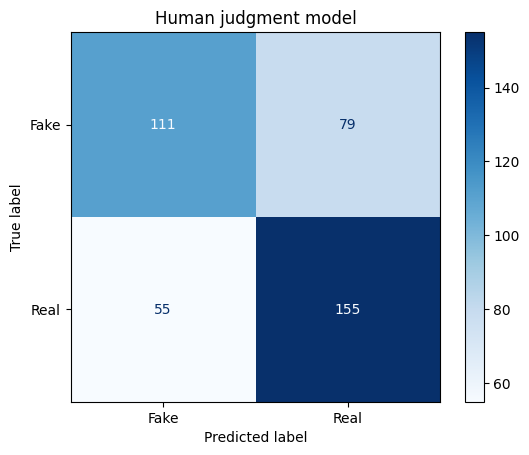

In [ ]:
judgment_pipe = Pipeline([
    ('clf', RandomForestClassifier(
        max_depth=10,
        min_samples_leaf=20,
        max_features=0.75,
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

X = df_agg_rating.drop(['label', 'img_id', 'edit_type', 'binary_rating', 'rating_mean'], axis=1)
y = df_agg_rating['binary_rating']

scores = cross_val_score(
    judgment_pipe, X, y,
    cv=cv,
    scoring='f1_macro'
)

print('F1 Macro:', scores)
print(f'F1-macro: {np.mean(scores):.3f} ± {np.std(scores):.3f}')


y_pred = cross_val_predict(
    judgment_pipe,
    X,
    y,
    cv=cv
)

print(classification_report(y, y_pred))

cm = confusion_matrix(y, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Fake', 'Real']
)

disp.plot(cmap='Blues', values_format='d')
plt.title('Human judgment model')
plt.show()

#### Hyperparameter tuning

In [ ]:
param_dist = {
    'clf__n_estimators': [100, 200, 300, 500],
    'clf__max_depth': [4, 6, 8, 10, None],
    'clf__min_samples_leaf': [1, 5, 10, 20],
    'clf__max_features': ['sqrt', 'log2', 0.5, 0.75],
    'clf__class_weight': ['balanced', None]
}

search = RandomizedSearchCV(
    judgment_pipe,
    param_distributions=param_dist,
    n_iter=30,
    scoring='balanced_accuracy',
    cv=5,
    random_state=42,
    n_jobs=-1
)

search.fit(X, y)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('clf',
                                              RandomForestClassifier(max_depth=10,
                                                                     max_features=0.75,
                                                                     min_samples_leaf=20,
                                                                     n_estimators=200,
                                                                     n_jobs=-1,
                                                                     random_state=42))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'clf__class_weight': ['balanced', None],
                                        'clf__max_depth': [4, 6, 8, 10, None],
                                        'clf__max_features': ['sqrt', 'log2',
                                                              0.5, 0.75],
                                        'clf__min_samples_leaf': [1, 5, 10, 20],
                                        'clf__n_estimators': [100, 200, 300,
                                                              500]},
                   random_state=42, scoring='balanced_accuracy')

#### Assessing model performance

In [ ]:
judgment_pipe.fit(X, y)

perm_importance = permutation_importance(
    judgment_pipe,
    X,
    y,
    scoring='f1_macro',
    n_repeats=30,
    random_state=42,
    n_jobs=-1
)

importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(importance_df)

              feature  importance_mean  importance_std
10  mean_saccade_mean         0.126843        0.021635
7          x_span_std         0.019142        0.009952
14     pooled_entropy         0.015230        0.010691
4          std_y_mean         0.013064        0.007069
0        num_fix_mean         0.011115        0.005186
12    dispersion_mean         0.010992        0.006947
2          std_x_mean         0.009098        0.006406
5           std_y_std         0.008893        0.005374
13     dispersion_std         0.007771        0.003442
8         y_span_mean         0.007553        0.005837
3           std_x_std         0.006126        0.006537
9          y_span_std         0.006005        0.002245
11   mean_saccade_std         0.000782        0.003387
6         x_span_mean        -0.003133        0.004997
1         num_fix_std        -0.003900        0.003027


#### Gaze + Rating Model

Predicting whether an image is real or fake based on combined eye movements and participant authenticity ratings.

F1 Macro: [0.89455846 0.78642258 0.80878838 0.72954699 0.79636364]
F1-macro: 0.803 ± 0.053
              precision    recall  f1-score   support

        fake       0.96      0.80      0.88       300
        real       0.61      0.91      0.73       100

    accuracy                           0.83       400
   macro avg       0.79      0.86      0.80       400
weighted avg       0.87      0.83      0.84       400



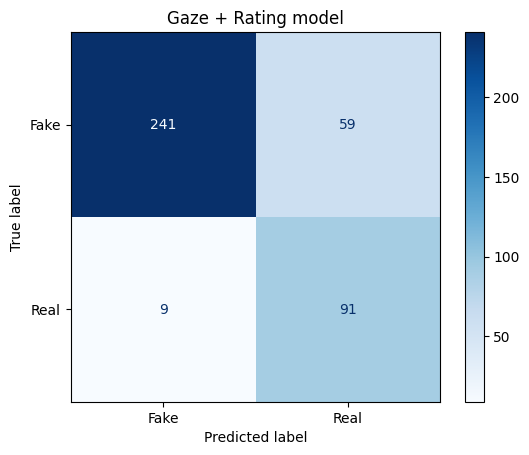

In [ ]:
gaze_rating_pipe = Pipeline([
    ('clf', RandomForestClassifier(
        max_depth=8,
        min_samples_leaf=20,
        max_features=0.5,
        n_estimators=300,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

X = df_agg_rating.drop(['label', 'img_id', 'edit_type', 'binary_rating'], axis=1)
y = df_agg_rating['label']

scores = cross_val_score(
    gaze_rating_pipe, X, y,
    cv=cv,
    scoring='f1_macro'
)

print('F1 Macro:', scores)
print(f'F1-macro: {np.mean(scores):.3f} ± {np.std(scores):.3f}')


y_pred = cross_val_predict(
    gaze_rating_pipe,
    X,
    y,
    cv=cv
)

print(classification_report(y, y_pred))

cm = confusion_matrix(y, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Fake', 'Real']
)

disp.plot(cmap='Blues', values_format='d')
plt.title('Gaze + Rating model')
plt.show()

#### Hyperparameter tuning

In [ ]:
param_dist = {
    'clf__n_estimators': [100, 200, 300, 500],
    'clf__max_depth': [4, 6, 8, 10, None],
    'clf__min_samples_leaf': [1, 5, 10, 20],
    'clf__max_features': ['sqrt', 'log2', 0.5, 0.75],
    'clf__class_weight': ['balanced', None]
}

search = RandomizedSearchCV(
    gaze_rating_pipe,
    param_distributions=param_dist,
    n_iter=30,
    scoring='balanced_accuracy',
    cv=5,
    random_state=42,
    n_jobs=-1
)

search.fit(X, y)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('clf',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     max_depth=8,
                                                                     max_features=0.5,
                                                                     min_samples_leaf=20,
                                                                     n_estimators=300,
                                                                     n_jobs=-1,
                                                                     random_state=42))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'clf__class_weight': ['balanced', None],
                                        'clf__max_depth': [4, 6, 8, 10, None],
                                        'clf__max_features': ['sqrt', 'log2',
                                                              0.5, 0.75],
                                        'clf__min_samples_leaf': [1, 5, 10, 20],
                                        'clf__n_estimators': [100, 200, 300,
                                                              500]},
                   random_state=42, scoring='balanced_accuracy')

#### Assessing model performance

In [ ]:
gaze_rating_pipe.fit(X, y)

perm_importance = permutation_importance(
    gaze_rating_pipe,
    X,
    y,
    scoring='f1_macro',
    n_repeats=30,
    random_state=42,
    n_jobs=-1
)

# Create ranked dataframe
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(importance_df)

              feature  importance_mean  importance_std
14        rating_mean         0.331442        0.027638
0        num_fix_mean         0.000000        0.000000
2          std_x_mean         0.000000        0.000000
1         num_fix_std         0.000000        0.000000
4          std_y_mean         0.000000        0.000000
5           std_y_std         0.000000        0.000000
6         x_span_mean         0.000000        0.000000
3           std_x_std         0.000000        0.000000
7          x_span_std         0.000000        0.000000
8         y_span_mean         0.000000        0.000000
10  mean_saccade_mean         0.000000        0.000000
9          y_span_std         0.000000        0.000000
11   mean_saccade_std         0.000000        0.000000
12    dispersion_mean         0.000000        0.000000
13     dispersion_std         0.000000        0.000000
15     pooled_entropy         0.000000        0.000000


#### Rating only model

Model that predicts images as real or fake using only human ratings

In [ ]:
df_agg_rating_small = df_agg_rating.drop(['num_fix_mean',	'num_fix_std',	'std_x_mean',	'std_x_std',	'std_y_mean',	'std_y_std',	'x_span_mean',	'x_span_std',	'y_span_mean',	'y_span_std',	'mean_saccade_mean',	'mean_saccade_std',	'dispersion_mean',	'dispersion_std',	'pooled_entropy', 'binary_rating'], axis=1)

F1 Macro: [0.89455846 0.80418    0.83430616 0.72954699 0.81291599]
F1-macro: 0.815 ± 0.053
              precision    recall  f1-score   support

        fake       0.97      0.81      0.88       300
        real       0.62      0.93      0.74       100

    accuracy                           0.84       400
   macro avg       0.80      0.87      0.81       400
weighted avg       0.88      0.84      0.85       400



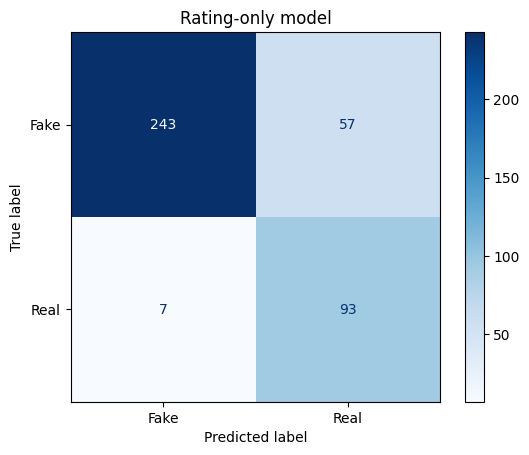

In [ ]:
rating_pipe = Pipeline([
    ('clf', RandomForestClassifier(
        min_samples_leaf=10,
        n_estimators=200,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

X = df_agg_rating_small.drop(['label', 'img_id', 'edit_type'], axis=1)
y = df_agg_rating_small['label']

scores = cross_val_score(
    rating_pipe, X, y,
    cv=cv,
    scoring='f1_macro'
)

print('F1 Macro:', scores)

print(f'F1-macro: {np.mean(scores):.3f} ± {np.std(scores):.3f}')


y_pred = cross_val_predict(
    rating_pipe,
    X,
    y,
    cv=cv
)

print(classification_report(y, y_pred))

cm = confusion_matrix(y, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Fake', 'Real']
)

disp.plot(cmap='Blues', values_format='d')
plt.title('Rating-only model')
plt.show()

#### Hyperparameter tuning

In [ ]:
param_dist = {
    'clf__n_estimators': [100, 200, 300, 500],
    'clf__max_depth': [4, 6, 8, 10, None],
    'clf__min_samples_leaf': [1, 5, 10, 20],
    'clf__max_features': ['sqrt', 'log2', 0.5, 0.75],
    'clf__class_weight': ['balanced', None]
}

search = RandomizedSearchCV(
    rating_pipe,
    param_distributions=param_dist,
    n_iter=30,
    scoring='balanced_accuracy',
    cv=5,
    random_state=42,
    n_jobs=-1
)

search.fit(X, y)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('clf',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     min_samples_leaf=10,
                                                                     n_estimators=200,
                                                                     n_jobs=-1,
                                                                     random_state=42))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'clf__class_weight': ['balanced', None],
                                        'clf__max_depth': [4, 6, 8, 10, None],
                                        'clf__max_features': ['sqrt', 'log2',
                                                              0.5, 0.75],
                                        'clf__min_samples_leaf': [1, 5, 10, 20],
                                        'clf__n_estimators': [100, 200, 300,
                                                              500]},
                   random_state=42, scoring='balanced_accuracy')

### Plotting

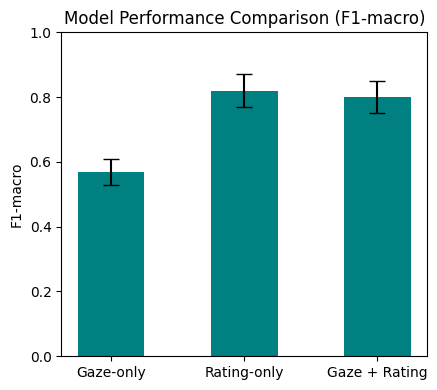

In [ ]:
models = ['Gaze-only', 'Rating-only', 'Gaze + Rating']

f1_means = [0.57, 0.82, 0.8]

f1_stds = [0.04, 0.05, 0.05]

x = np.arange(len(models))

plt.figure(figsize=(4.5, 4))

plt.bar(
    x,
    f1_means,
    yerr=f1_stds,
    capsize=6,
    width=0.5,
    color='teal'
)

plt.xticks(x, models)
plt.ylabel('F1-macro')
plt.ylim(0, 1.0)
plt.title('Model Performance Comparison (F1-macro)')

plt.tight_layout()
plt.show()